In [88]:
import requests
import plotly
import matplotlib.pyplot as plt
# from pylab import mpl, plt
import numpy as np
import yfinance as yf
import os
import sys
import pandas as pd
from scipy.stats import pearsonr
from datetime import datetime
from dateutil.relativedelta import relativedelta
from configparser import ConfigParser
import nasdaqdatalink

https://aroussi.com/post/python-yahoo-finance

# Global Vars

In [137]:
blue_chip_stocks = [
    'DIS',
    'AAPL',
    'AXP',
    'BAC',
    'C',
    'CAT',
    'MCD',
    'MMM',
    'WMT',
    'GS',
    'MSFT'
]

In [138]:
DT_STATIC = datetime(2023,9,29)
DT_PRIOR = DT_STATIC - relativedelta(years=6) # prior x years

In [139]:
config = ConfigParser()
config.read('./config.ini')

['./config.ini']

In [140]:
# INITIALIZE API Key
nasdaqdatalink.ApiConfig.api_key = config['APIKeys']['quandl']

# Functions / Classes

In [141]:
class TickerObj:
    def __init__(self, name):
        self.ticker = name
        self.obj = yf.Ticker(name)
        self.data = self.obj.history(start=DT_PRIOR, end=DT_STATIC)\
            .reset_index().sort_values('Date', ascending=True).reset_index(drop=True)
        self.data.Date = pd.to_datetime(self.data.Date)
        self.info = self.obj.info

    def obtainSma(self):
        self.data['SMA_42'] = self.data['Close'].rolling(42).mean()
        self.data['SMA_252'] = self.data['Close'].rolling(252).mean()

# Import Data

In [142]:
# USING Nasdaq Data Link
# data = nasdaqdatalink.get('FSE/SAP_X', start_date='2018-1-1', end_date='2020-05-01')

In [143]:
obj_spy = TickerObj('SPY')

# SMA

In [144]:
obj_spy.obtainSma()

In [145]:
# drop data if it doesn't have all SMAs
obj_spy.data.dropna(inplace=True)

Text(0.5, 0, 'Date')

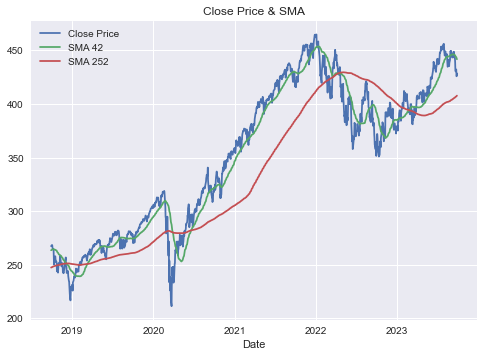

In [146]:
plt.style.use('seaborn')
plt.plot(obj_spy.data.Date, obj_spy.data.Close, label='Close Price')
plt.plot(obj_spy.data.Date, obj_spy.data.SMA_42, label='SMA 42')
plt.plot(obj_spy.data.Date, obj_spy.data.SMA_252, label='SMA 252')
plt.legend()
plt.title('Close Price & SMA')
plt.xlabel('Date')

In [147]:
# buy when 42 sma exceeds 252 sma
obj_spy.data['position'] = np.where(obj_spy.data['SMA_42'] > obj_spy.data['SMA_252'], 1, -1)

Text(0.5, 0, 'Date')

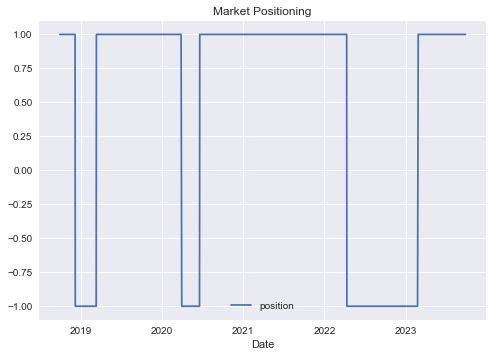

In [150]:
plt.style.use('seaborn')
plt.plot(obj_spy.data.Date, obj_spy.data.position, label='position')
plt.legend()
plt.title('Market Positioning')
plt.xlabel('Date')

In [151]:
# get log returns
obj_spy.data['returns'] = np.log(obj_spy.data['Close'] / obj_spy.data['Close'].shift(1))

Text(0.5, 1.0, 'SPY Log Returns')

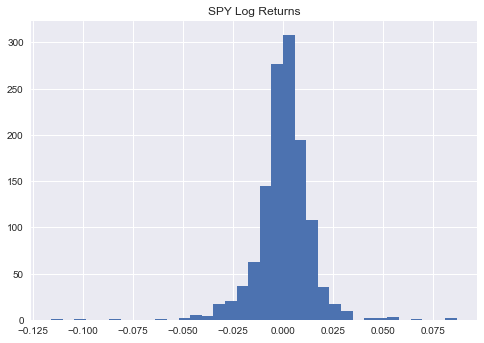

In [152]:
plt.hist(obj_spy.data['returns'], bins=35)
plt.title('SPY Log Returns')

In [153]:
# get log returns of strategy
obj_spy.data['strategy_returns'] = obj_spy.data['position'].shift(1) * obj_spy.data['returns']

In [154]:
# get single log returns over the time period
obj_spy.data[['returns', 'strategy_returns']].sum()

returns             0.471434
strategy_returns    0.171608
dtype: float64

In [155]:
obj_spy.data[['returns', 'strategy_returns']].sum().apply(np.exp)

returns             1.602290
strategy_returns    1.187212
dtype: float64